# Style Transfer

<img src="https://i0.wp.com/chelseatroy.com/wp-content/uploads/2018/12/neural_style_transfer.png?resize=768%2C311&ssl=1">

La idea de este trabajo final es reproducir el siguiente paper:

https://arxiv.org/pdf/1508.06576.pdf

El objetivo es transferir el estilo de una imagen dada a otra imagen distinta. 

Como hemos visto en clase, las primeras capas de una red convolucional se activan ante la presencia de ciertos patrones vinculados a detalles muy pequeños.

A medida que avanzamos en las distintas capas de una red neuronal convolucional, los filtros se van activando a medida que detectan patrones de formas cada vez mas complejos.

Lo que propone este paper es asignarle a la activación de las primeras capas de una red neuronal convolucional (por ejemplo VGG19) la definición del estilo y a la activación de las últimas capas de la red neuronal convolucional, la definición del contenido.

La idea de este paper es, a partir de dos imágenes (una que aporte el estilo y otra que aporte el contenido) analizar cómo es la activación de las primeras capas para la imagen que aporta el estilo y cómo es la activación de las últimas capas de la red convolucional para la imagen que aporta el contenido. A partir de esto se intentará sintetizar una imagen que active los filtros de las primeras capas que se activaron con la imagen que aporta el estilo y los filtros de las últimas capas que se activaron con la imagen que aporta el contenido.

A este procedimiento se lo denomina neural style transfer.

# En este trabajo se deberá leer el paper mencionado y en base a ello, entender la implementación que se muestra a continuación y contestar preguntas sobre la misma.

# Una metodología posible es hacer una lectura rápida del paper (aunque esto signifique no entender algunos detalles del mismo) y luego ir analizando el código y respondiendo las preguntas. A medida que se planteen las preguntas, volviendo a leer secciones específicas del paper terminará de entender los detalles que pudieran haber quedado pendientes.

Lo primero que haremos es cargar dos imágenes, una que aporte el estilo y otra que aporte el contenido. A tal fin utilizaremos imágenes disponibles en la web.

In [1]:
# Imagen para estilo
!wget https://upload.wikimedia.org/wikipedia/commons/5/52/La_noche_estrellada1.jpg

# Imagen para contenido
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Neckarfront_T%C3%BCbingen_Mai_2017.jpg/775px-Neckarfront_T%C3%BCbingen_Mai_2017.jpg

# Creamos el directorio para los archivos de salida
!mkdir /content/output

--2020-02-21 19:56:43--  https://upload.wikimedia.org/wikipedia/commons/5/52/La_noche_estrellada1.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 223725 (218K) [image/jpeg]
Saving to: ‘La_noche_estrellada1.jpg.1’

La_noche_estrellada 100%[===================>] 218.48K  --.-KB/s    in 0.02s   

2020-02-21 19:56:43 (11.8 MB/s) - ‘La_noche_estrellada1.jpg.1’ saved [223725/223725]

--2020-02-21 19:56:46--  https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Neckarfront_T%C3%BCbingen_Mai_2017.jpg/775px-Neckarfront_T%C3%BCbingen_Mai_2017.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 153015 (149K) 

In [2]:
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import argparse

from keras.applications import vgg19
from keras import backend as K
from pathlib import Path

Using TensorFlow backend.


In [0]:
# Definimos las imagenes que vamos a utilizar, y el directorio de salida

base_image_path = Path("/content/775px-Neckarfront_Tübingen_Mai_2017.jpg")
style_reference_image_path = Path("/content/La_noche_estrellada1.jpg")
result_prefix = Path("/content/output")

#base_image_path = Path("/content/745px-Neckarfront_Tübingen_Mai_2017.jpg")

In [0]:
# Definimos el tamaño de las imágenes a utilizar
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

#por si quiero correr con imagenes mas grandes, puedo usar esto, ojo con las proporcines entre las imagenes
#img_nrows = height
#img_ncols = width


In [0]:
#parametros de la loss

content_weight = 0.0001    #(alpha)
style_weight = 1   #(beta)
ratio = content_weight/style_weight

total_variation_weight = 0    #0.1

wn=1      #true for starting from white noise

In [0]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

In [0]:
def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [0]:
# get tensor representations of our images
# K.variable convierte un numpy array en un tensor, para 
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))

In [9]:
# la imagen creada que debiera ser ruido blanco segun el paper...
combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

Aclaración:

La siguiente celda sirve para procesar las tres imagenes (contenido, estilo y salida) en un solo batch.

In [0]:
# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

In [11]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)

#print('Model loaded.')
model.summary()










Model loaded.


In [12]:
# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

outputs_dict

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 400, 517, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 400, 517, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 200, 258, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 200, 258, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 200, 258, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 100, 129, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 100, 129, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 100, 129, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 100, 129, 256) dtype=float32>,
 'block3_conv4': <tf.Tensor 'block3_conv4/Relu:0' shape=(3, 100, 129, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 50, 64, 256) dtype=float32>,
 

In [13]:
outputs_dict['block4_conv2'][0, :, :, :]

<tf.Tensor 'strided_slice:0' shape=(50, 64, 512) dtype=float32>

# 4) En la siguientes celdas:

- ¿Qué es la matriz de Gram?¿Para qué se usa?
- ¿Por qué se permutan las dimensiones de x?

In [0]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

# 5) Losses:




In [0]:
def content_loss(base, combination):
    return 0.5 * K.sum(K.square(combination - base))    # 1.0

In [0]:
# Armamos la loss total
loss = K.variable(0.0)

if wn:        #para whitenoise usar block3, para imagen usar 'block5_conv2'
  layer_features = outputs_dict['block3_conv2']       
else:
  layer_features = outputs_dict['block5_conv2']       

base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss = content_weight * content_loss(base_image_features, combination_features)

In [0]:
def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = K.int_shape(style)[2]                      #3
    size = K.int_shape(style)[0] * K.int_shape(style)[1]  #img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [0]:
feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :] 
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    
    loss = loss + (style_weight / len(feature_layers)) * sl

In [0]:
def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(
        x[:, 0:img_nrows - 1, 0:img_ncols - 1, :] - x[:, 1:, 0:img_ncols - 1, :])
    b = K.square(
        x[:, 0:img_nrows - 1, 0:img_ncols - 1, :] - x[:, 0:img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [0]:
loss = loss + total_variation_weight * total_variation_loss(combination_image)

In [22]:
grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
def eval_loss_and_grads(x):
    x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

In [0]:
# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

# 7) Ejecute la siguiente celda y observe las imágenes de salida en cada iteración.

In [0]:
import matplotlib.pyplot as plt

iterations = 100

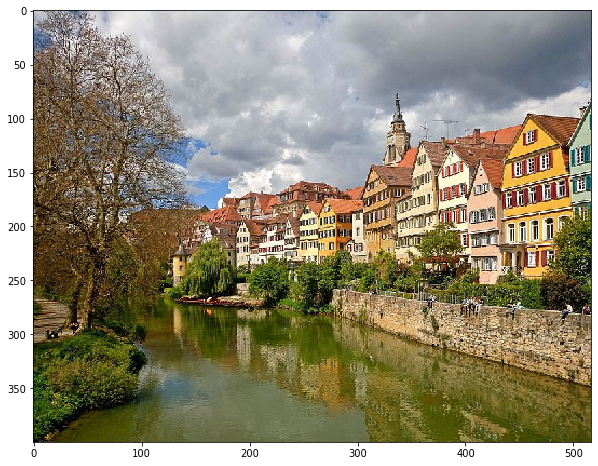

In [26]:
plt.figure(figsize = (10,10))
plt.imshow(load_img(base_image_path, target_size=(img_nrows, img_ncols)))

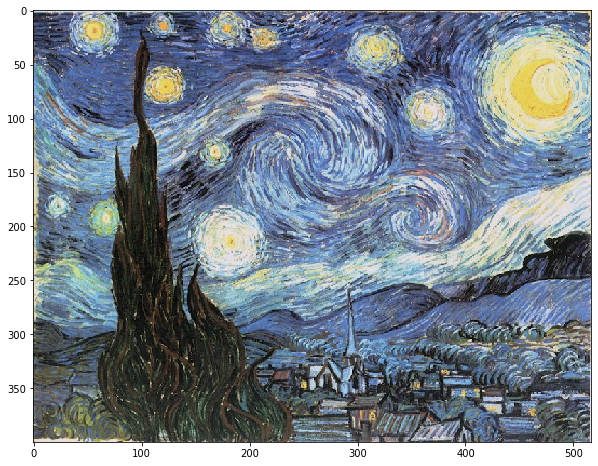

In [27]:
plt.figure(figsize = (10,10))
plt.imshow(load_img(style_reference_image_path, target_size=(img_nrows, img_ncols)))

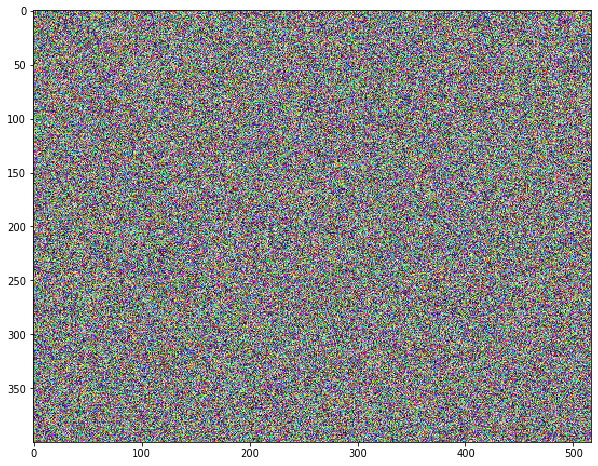

In [28]:
if wn:
  wnoise=np.random.randint(0,256,(img_nrows,img_ncols,3))
  plt.figure(figsize = (10,10))
  plt.imshow(wnoise)

In [29]:
x0 = img_to_array(load_img(base_image_path, target_size=(img_nrows, img_ncols)))
#x0 = img_to_array(load_img(style_reference_image_path, target_size=(img_nrows, img_ncols)))
if wn:
  x0 = np.random.randint(0,256,(img_nrows,img_ncols,3))
print(np.min(x0[:, :, 0]), np.max(x0[:, :, 0]), np.min(x0[:, :, 1]), np.max(x0[:, :, 1]), np.min(x0[:, :, 2]), np.max(x0[:, :, 2]))

x1 = vgg19.preprocess_input(np.expand_dims(x0, axis=0))
print(np.min(x1[:, :, 0]), np.max(x1[:, :, 0]), np.min(x1[:, :, 1]), np.max(x1[:, :, 1]), np.min(x1[:, :, 2]), np.max(x1[:, :, 2]))

x2 = x1.reshape((img_nrows, img_ncols, 3))
# Remove zero-center by mean pixel
x2[:, :, 0] += 103.939
x2[:, :, 1] += 116.779
x2[:, :, 2] += 123.68
print(np.min(x2[:, :, 0]), np.max(x2[:, :, 0]), np.min(x2[:, :, 1]), np.max(x2[:, :, 1]), np.min(x2[:, :, 2]), np.max(x2[:, :, 2]))

0 255 0 255 0 255
-122.68 151.061 -123.68 151.061 -123.68 151.061
0.0 255.0 0.0 255.0 0.0 255.0


In [30]:
#select initial guess/image for grad search
if wn:   #start from white noise, so more iterations needed...
  x = vgg19.preprocess_input(np.expand_dims(wnoise, axis=0))
  iterations *= 2
else:    #start from content image 
  x = preprocess_image(base_image_path)

evalu = Evaluator()
min_val=np.zeros(iterations)
search_lines=np.floor_divide(img_nrows,20)
img_bright=list(zip(-123.7*np.ones(x.flatten().shape), 151*np.ones(x.flatten().shape)))
#img_bright=None

# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
for i in range(iterations):
#    print('Start of iteration', i)
    start_time = time.time()
    x, min_val[i], info = fmin_l_bfgs_b(evalu.loss, x.flatten(),
                                     fprime=evalu.grads, bounds=img_bright, maxfun=search_lines)
    # save current generated image
    img_o = deprocess_image(x.copy())
    fname = result_prefix / ('output_at_iteration_%d.png' % i)
    save_img(fname, img_o)
    if i in range(0,iterations,10):
      plt.figure(figsize = (8,8))
      plt.imshow(img_o)
      plt.show()
    end_time = time.time()
    #print('Image saved as', fname)
    print('Current loss value:', min_val[i])
    print('Iteration %d completed in %fs' % (i, end_time - start_time))

Output hidden; open in https://colab.research.google.com to view.

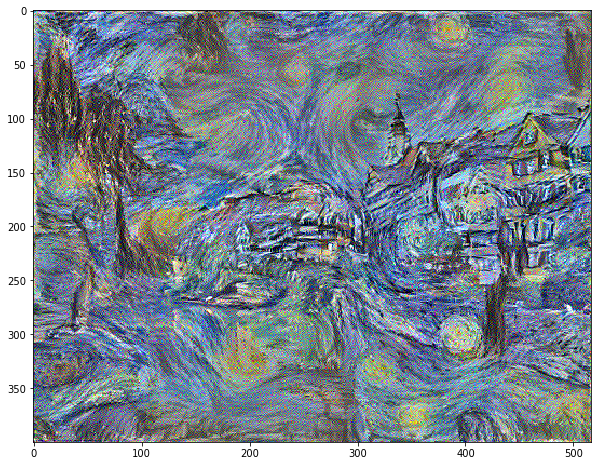

In [31]:
#last generated picture
plt.figure(figsize = (10,10))
plt.imshow(img_o)

In [32]:
xf = x.reshape((img_nrows, img_ncols, 3))
# Remove zero-center by mean pixel
xf[:, :, 0] += 103.939
xf[:, :, 1] += 116.779
xf[:, :, 2] += 123.68

print(np.min(xf[:, :, 0]), np.max(xf[:, :, 0]), np.min(xf[:, :, 1]), np.max(xf[:, :, 1]), np.min(xf[:, :, 2]), np.max(xf[:, :, 2]))
print(np.min(xf), np.max(xf))

-20.061000000000007 254.939 -7.221000000000004 267.779 -0.3199999999999932 274.68
-20.061000000000007 274.68


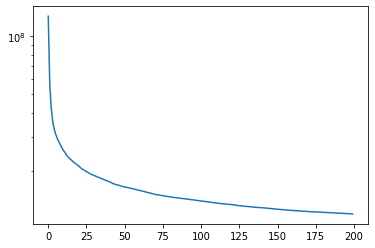

In [33]:
plt.plot(min_val[:])
plt.yscale('log')